In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("lm.mplstyle")

import os
import numpy as np
import samplebase as sb
import pandas as pd
import case_config

- 47 rates
- 14 different #realizations
- 10 runs each

In [2]:
DATA_ROOT = "/home/mho/Dropbox/phd/readdy_learn/reaction_learn_data"
crop_estimated_rates = True
gillespie_realizations = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]

In [3]:
with open(os.path.join(DATA_ROOT, 'case2_validation_alphas_and_solutions_averagefolds.npz'), 'rb') as f:
    X = np.load(f)
    rates = X['rates']
    l1_dev = X['l1_dev']
    alpha_val = X['alpha_val']

In [4]:
if crop_estimated_rates:
    for gillespie_realization in range(len(gillespie_realizations)):
        estimated_rates = rates[gillespie_realization]
        cropped_rates = estimated_rates[:]
        cropped_rates[cropped_rates < case_config.CASE1_CUTOFF] = 0.
        for arr in np.bitwise_or(cropped_rates >= case_config.CASE1_CUTOFF, cropped_rates == 0):
            assert all(arr)
        for i in range(l1_dev.shape[1]):
            l1_dev[gillespie_realization][i] = np.sum(np.abs(cropped_rates[i] - case_config.DESIRED_RATES))

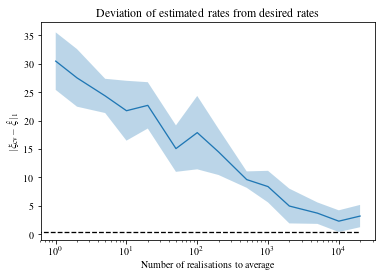

In [5]:
mean = np.mean(l1_dev, axis=1)
err = np.std(l1_dev, axis=1) #/ np.sqrt(10.) # 10 iids
plt.plot(gillespie_realizations, mean)
plt.fill_between(gillespie_realizations, y1=np.clip(mean-err, 0., 1e16), y2=mean+err, alpha=0.3)
plt.xscale("log")
plt.hlines(.38, xmin=0, xmax=gillespie_realizations[-1], linestyles='dashed')
plt.xlabel("Number of realisations to average")
plt.ylabel(r"$|\xi_\mathrm{cv}-\hat{\xi}|_1$")
plt.title("Deviation of estimated rates from desired rates")
ymin, ymax = plt.ylim()
plt.ylim(-1,ymax)
plt.savefig("case2_convergence_averagefolds.pdf", bbox_inches="tight", transparent=True)

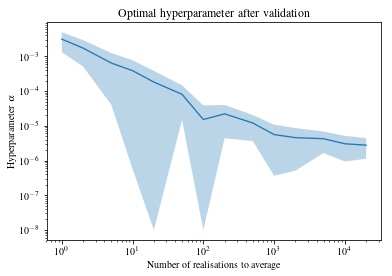

In [23]:
mean = np.mean(alpha_val, axis=1)
err = np.std(alpha_val, axis=1) #/ np.sqrt(10.) # 10 iids
plt.plot(gillespie_realizations, mean)
plt.fill_between(gillespie_realizations, y1=np.clip(mean-err, 1e-8, 1.), y2=mean+err, alpha=0.3)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of realisations to average")
plt.ylabel(r"Hyperparameter $\alpha$")
plt.title("Optimal hyperparameter after validation")
#ymin, ymax = plt.ylim()
#plt.ylim(-1,ymax)
plt.savefig("case2_best_hyperparameter_averagefolds.pdf", bbox_inches="tight", transparent=True)